(supervised:linear-regression:example2)=
# Worked Example: House Prices II

We try to improve prediction of house prices based on [Erdogan Seref's](https://www.kaggle.com/scriptsultan) (unreachable in 2023) German housing dataset from [www.immobilienscout24.de](https://www.immobilienscout24.de) published at [www.kaggle.com](https://www.kaggle.com/scriptsultan/german-house-prices) (unreachable in 2023) under a [Attribution-NonCommercial-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-nc-sa/4.0).

We load preprocessed data and adjust data types.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import sklearn.pipeline as pipeline

data_path = 'german_housing_preprocessed.csv'
regions_path = 'regions.csv'

In [2]:
data = pd.read_csv(data_path, index_col=0)

data['Type'] = data['Type'].astype('category')
data['Condition'] = data['Condition'].astype('category')
data['Garage_type'] = data['Garage_type'].astype('category')

data['Condition'] = data['Condition'].cat.reorder_categories([
    'first occupation',
    'first occupation after refurbishment',
    'maintained',
    'renovated',
    'modernized',
    'refurbished',
    'fixer-upper',
    'dilapidated'
])

In [3]:
data.head()

Price               Type  Living_space       Lot  Rooms  Bathrooms  \
0   13.118355  Multiple dwelling      4.663439  5.433722    5.5        1.0   
2   13.526494          Farmhouse      5.093075  4.406719    5.0        2.0   
3   12.464583          Farmhouse      4.941642  6.701960    4.0        2.0   
8   12.804909             Duplex      5.424950  6.880384   10.0        4.0   
10  14.375126  Mid-terrace house      5.347108  7.286192    6.0        2.0   

    Floors  Year_built  Year_renovated    Condition              State  \
0      2.0    2.772589        2.772589   modernized  Baden-Württemberg   
2      4.0    2.079442        2.079442  dilapidated  Baden-Württemberg   
3      2.0    4.795791        3.044522  fixer-upper  Baden-Württemberg   
8      2.0    5.356586        1.791759   modernized  Baden-Württemberg   
10     3.0    4.406719        1.945910   modernized  Baden-Württemberg   

                 City                    Place  Garages          Garage_type  
0       Bodenseekreis              Bermatingen      2.0  Outside parking lot  
2   Esslingen (Kreis)               Ostfildern      1.0               Garage  
3    Waldshut (Kreis)  Bonndorf im Schwarzwald      1.0               Garage  
8            Enzkreis                Neuenbürg      8.0  Outside parking lot  
10          Stuttgart                Schönberg      2.0               Garage

## More Data

Results obtained from linear regression showed that input variables do not suffice to explain the targets. Thus, we should add more input variables. When preprocessing the data we dropped several columns. Keeping them could increase prediction quality slightly, but there were several good reasons to drop those columns. The main reason were lots of missing values in those columns.

A far better idea is to collect additional data. What features of a house influence the selling price? Of course its location! Up to now we did not use location information at all, but we have location information available. There are columns `State`, `City`, `Place`. But city names do not help. We need something like proximity to big cities or nice landscape. Adding a layer of abstraction we might ask for the demand for houses and the whealth of potential buyers. So we should head out for statistical information about local real estate markets and about economic power of different regions in Germany.

Everything we need is publicly available at [www.regionalstatistik.de](https://www.regionalstatistik.de) provided by *Statistische Ämter des Bundes und der Länder* under the license [Datenlizenz Deutschland – Namensnennung – Version 2.0](https://www.govdata.de/dl-de/by-2-0). Clicking here and there we find two interesting tables:
* [annual income per inhabitant](https://www.regionalstatistik.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=1&levelid=1614168819692&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=AI-S-01&auswahltext=&werteabruf=Werteabruf#abreadcrumb)
* [prices for construction ground](https://www.regionalstatistik.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=1&levelid=1614168973527&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=61511-01-03-4&auswahltext=&werteabruf=Werteabruf#abreadcrumb)

From those tables we may compile a table with 4 columns for region id, region name, income, ground prices.

The difficult part is matching region names in German housing data set with region names in the region table. Here is some code doing the job:

In [4]:
# remove rows with missing location information
data = data.dropna(subset=('State', 'City'))

# reindex to remove gaps in the index
data.index = pd.RangeIndex(0, len(data))

In [5]:
regions = pd.read_csv(regions_path)

regions.head(5)

id                                          region  income  prices
0     0                                     Deutschland   22623  137.67
1     1                              Schleswig-Holstein   22864   85.30
2  1001                     Flensburg, Kreisfreie Stadt   19296   85.30
3  1002        Kiel, Landeshauptstadt, Kreisfreie Stadt   19263   85.30
4  1003            Lübeck, Hansestadt, Kreisfreie Stadt   20363  110.84

In [6]:
data['city_short'] = data['City'].str.replace(' (Kreis)', '', regex=False)
data['region_idx'] = 0

for (idx, city_short) in enumerate(data['city_short']):
    find_results = regions['region'].str.find(str(city_short))
    if not (find_results > -1).any():
        #print(city_short)
        if data.loc[idx, 'State'] == 'Hamburg':
            find_results = regions['region'].str.find('Hamburg')
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        elif data.loc[idx, 'State'] == 'Bremen':
            find_results = regions['region'].str.find('Bremen')
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        elif data.loc[idx, 'State'] == 'Berlin':
            district = city_short.split('(')[-1][0:-1]
            if district == 'Weißensee':
                district = 'Pankow'
            if district == 'Prenzlauer Berg':
                district = 'Pankow'
            if district == 'Hohenschönhausen':
                district = 'Lichtenberg'
            if district == 'Wedding':
                district = 'Berlin-Mitte'
            find_results = regions['region'].str.find(district)
            #print('***', city_short, ':', district, '-->', regions['Region'][find_results > -1])
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        elif city_short == 'Neuss (Rhein-Kreis)':
            find_results = regions['region'].str.find('Neuss')
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        elif city_short == 'Sankt Wendel':
            find_results = regions['region'].str.find('Wendel')
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        elif city_short == 'Stadtverband Saarbrücken':
            find_results = regions['region'].str.find('Saarbrücken, Regionalverband')
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        elif city_short.split()[1] in ('in', 'im', 'an', 'am'):
            if city_short.split()[0] == 'Neustadt':
                find_results = regions['region'].str.find(city_short.split()[-1])
            else:
                find_results = regions['region'].str.find(city_short.split()[0])
            #print('***', city_short, '-->', regions.loc[find_results > -1, 'Region'])
            data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]
        else:
            print('NOT FOUND:', city_short)
            
    else:
        # take last match (smallest region)
        data.loc[idx, 'region_idx'] = regions.index[find_results > -1][-1]

In [7]:
data['Region_id'] = regions.loc[data['region_idx'], 'id'].values
data['Income'] = regions.loc[data['region_idx'], 'income'].values
data['Land_prices'] = regions.loc[data['region_idx'], 'prices'].values

In [8]:
data = data.drop(columns=['city_short', 'region_idx'])

In [9]:
data.head(5)

Price               Type  Living_space       Lot  Rooms  Bathrooms  \
0  13.118355  Multiple dwelling      4.663439  5.433722    5.5        1.0   
1  13.526494          Farmhouse      5.093075  4.406719    5.0        2.0   
2  12.464583          Farmhouse      4.941642  6.701960    4.0        2.0   
3  12.804909             Duplex      5.424950  6.880384   10.0        4.0   
4  14.375126  Mid-terrace house      5.347108  7.286192    6.0        2.0   

   Floors  Year_built  Year_renovated    Condition              State  \
0     2.0    2.772589        2.772589   modernized  Baden-Württemberg   
1     4.0    2.079442        2.079442  dilapidated  Baden-Württemberg   
2     2.0    4.795791        3.044522  fixer-upper  Baden-Württemberg   
3     2.0    5.356586        1.791759   modernized  Baden-Württemberg   
4     3.0    4.406719        1.945910   modernized  Baden-Württemberg   

                City                    Place  Garages          Garage_type  \
0      Bodenseekreis              Bermatingen      2.0  Outside parking lot   
1  Esslingen (Kreis)               Ostfildern      1.0               Garage   
2   Waldshut (Kreis)  Bonndorf im Schwarzwald      1.0               Garage   
3           Enzkreis                Neuenbürg      8.0  Outside parking lot   
4          Stuttgart                Schönberg      2.0               Garage   

   Region_id  Income  Land_prices  
0       8435   26548       172.95  
1       8116   25449       387.06  
2       8337   25304       111.64  
3       8236   25496       192.18  
4       8111   25559      1500.34

## Preprocessing New Columns

Now that we have two now columns (`Income` and `Land_prices`) we should look at their values.

### `Income` Column

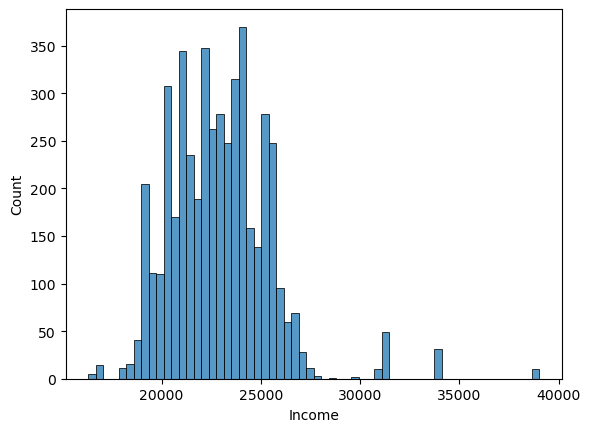

In [10]:
sns.histplot(data['Income'])
plt.show()

Log-scaling is not mandadory here, but it brings values to a similar range like the other columns. Without log-scaling we would have a column with very large range, which may result in problems when using regularization (see [](supervised:linear-regression:regularization)). Alternatively we could standardize all columns before doing linear regression.

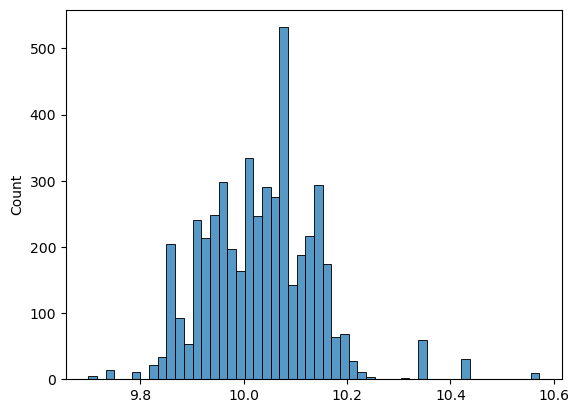

In [11]:
sns.histplot(np.log(data['Income'].to_numpy()))
plt.show()

In [12]:
data['Income'] = np.log(data['Income'].to_numpy())

### `Land_prices` Column

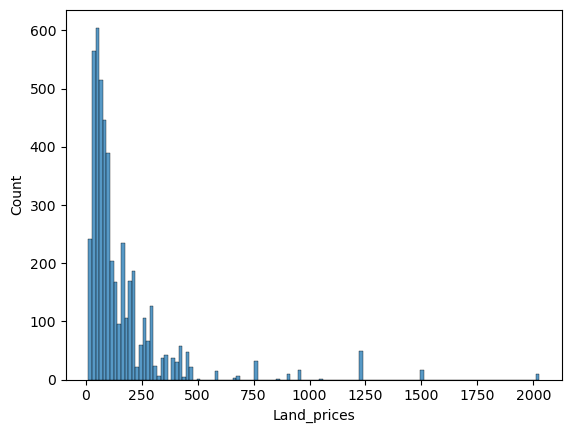

In [13]:
sns.histplot(data['Land_prices'])
plt.show()

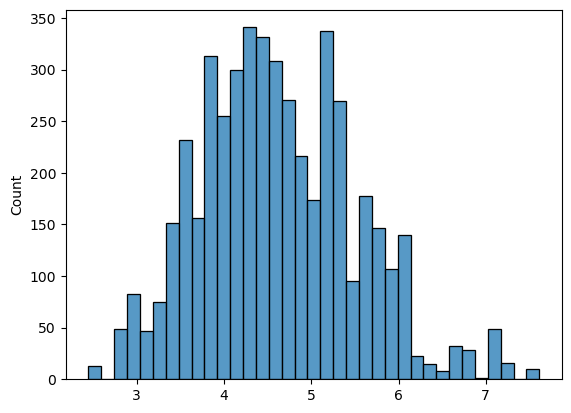

In [14]:
sns.histplot(np.log(data['Land_prices'].to_numpy()))
plt.show()

In [15]:
data['Land_prices'] = np.log(data['Land_prices'].to_numpy())

## Save Data

In [16]:
data.to_csv(data_path.replace('preprocessed', 'extended'))

## Linear Regression

Now we do linear regression as before, but with two additional columns.

In [17]:
data['Condition_codes'] = data['Condition'].cat.codes
data = pd.get_dummies(data, columns=['Type', 'Garage_type'], drop_first=True)

In [18]:
y = data['Price'].to_numpy()
X = data.drop(columns=['Price', 'Condition', 'State', 'City', 'Place', 'Region_id']).to_numpy()

print(X.shape, y.shape)

(4772, 23) (4772,)


In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print(y_train.size, y_test.size)

3817 955


In [20]:
steps = [('poly', preprocessing.PolynomialFeatures()),
         ('ridge', linear_model.Ridge())]

pipe = pipeline.Pipeline(steps)

param_grid = {'poly__degree': [1, 2, 3],
              'ridge__alpha': [0] + [2 ** k for k in range(5, 15)]}

gs = model_selection.GridSearchCV(pipe, param_grid=param_grid,
                                  scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

gs.fit(X_train, y_train)
best_params = gs.best_params_

## Evaluation

Now the interesting part. Do we see an increase in prediction quality?

In [21]:
print(best_params)

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)

y_test_pred = pipe.predict(X_test)

{'poly__degree': 2, 'ridge__alpha': 512}


In [22]:
rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
sigma = np.std(y_test)
print('RMSE:', rmse)
print('standard deviation:', sigma)
print('ratio:', rmse / sigma)

RMSE: 0.41784051720522897
standard deviation: 0.7969255717596182
ratio: 0.5243156099039885


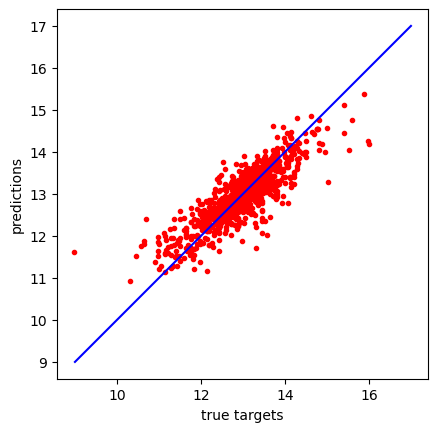

In [23]:
fig, ax = plt.subplots()
ax.plot(y_test, y_test_pred, 'or', markersize=3)
ax.plot([9, 17], [9, 17], '-b')
ax.set_xlabel('true targets')
ax.set_ylabel('predictions')
ax.set_aspect('equal')
plt.show()

Looks much better!

## Feature Importance

With a trained model we may look at feature importances to see which features have high influence on the selling price.

In [24]:
import sklearn.inspection as inspection

In [25]:
result = inspection.permutation_importance(pipe, X, y, n_jobs=-1)

In [26]:
cols = data.drop(columns=['Price', 'Condition', 'State', 'City', 'Place', 'Region_id']).columns
imp = pd.Series(result.importances_mean, index=cols)
imp = imp.sort_values(ascending=False)
imp

Land_prices                            0.402403
Living_space                           0.313045
Year_built                             0.169028
Lot                                    0.064657
Income                                 0.029009
Rooms                                  0.019429
Bathrooms                              0.019242
Type_Duplex                            0.017057
Type_Villa                             0.015990
Year_renovated                         0.011070
Condition_codes                        0.008705
Type_Mid-terrace house                 0.007865
Garage_type_Outside parking lot        0.007603
Floors                                 0.005987
Garages                                0.004356
Garage_type_Garage                     0.003244
Type_Corner house                      0.002825
Type_Multiple dwelling                 0.002599
Type_Single dwelling                   0.002530
Type_Farmhouse                         0.000998
Type_Special property                  0